In [5]:
import numpy as np
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")


Libraries imported successfully!


# Options Pricing Using Machine Learning - Real Market Data (AAPL)

## Research Notebook for Option Pricing Models

This notebook implements various machine learning approaches to price options using real market data from Apple Inc. (AAPL) options chains spanning 2021-2023.

### Methodology Overview
1. **Data Preprocessing**: Clean and transform real options market data
2. **Feature Engineering**: Create moneyness ratios, time to maturity, and normalized price features
3. **GARCH Modeling**: Estimate conditional volatility using GARCH(1,1)
4. **Model Training**: Implement MLP, LSTM, and GRU neural networks
5. **Model Evaluation**: Compare predictions against actual market prices
6. **Performance Analysis**: Assess model accuracy using multiple metrics

### Data Source
- **Asset**: Apple Inc. (AAPL) Options
- **Time Period**: 2022 (training period - diverse market conditions)
- **Data Points**: ~150K-200K options observations
- **Features**: Strike, Underlying Price, Implied Volatility, Volume, Greeks


## 1. Data Loading and Initial Exploration


In [6]:
# Load the raw AAPL options data
# Note: Column names have brackets, e.g., [QUOTE_DATE]
df_raw = pd.read_csv('aapl_2021_2023.csv', low_memory=False)

print(f"Dataset shape: {df_raw.shape}")
print(f"\nTotal observations: {len(df_raw):,}")
print(f"\nColumn names (first 10):")
print(df_raw.columns.tolist()[:10])
print(f"\nAll columns: {len(df_raw.columns)}")


Dataset shape: (548163, 33)

Total observations: 548,163

Column names (first 10):
['[QUOTE_UNIXTIME]', ' [QUOTE_READTIME]', ' [QUOTE_DATE]', ' [QUOTE_TIME_HOURS]', ' [UNDERLYING_LAST]', ' [EXPIRE_DATE]', ' [EXPIRE_UNIX]', ' [DTE]', ' [C_DELTA]', ' [C_GAMMA]']

All columns: 33


## 2. Data Cleaning and Preprocessing

Transform the raw AAPL options data to match the required format for option pricing models.

### Column Mapping:
- `UNDERLYING_LAST` → `underlying_stockprice` (Stock price)
- `C_LAST` → `option_price` (Call option price)
- `STRIKE` → `Strike` (Strike price)
- `C_VOLUME` → `Volume` (Trading volume)
- `QUOTE_DATE` → `Time` (Quote date)
- `C_IV` → `IV` (Implied volatility)
- `DTE` → Used to calculate `Maturity`


In [7]:
# Define data cleaning function (matching original notebook structure)
def data_cleaning_aapl(df):
    """
    Clean and transform AAPL options data to standard format.
    Similar to data_cleaning() function in original notebook.
    """
    df = df.copy()
    
    # Step 1: Column names have brackets, strip them
    df.columns = df.columns.str.strip().str.replace('[', '').str.replace(']', '')
    
    # Step 2: Rename columns to match expected format
    column_mapping = {
        'UNDERLYING_LAST': 'underlying_stockprice',
        'C_LAST': 'option_price',
        'STRIKE': 'Strike',
        'C_VOLUME': 'Volume',
        'QUOTE_DATE': 'Time',
        'C_IV': 'IV',
        'DTE': 'DTE'
    }
    
    # Select and rename columns (keep DTE for maturity calculation)
    cols_to_select = [col for col in column_mapping.keys() if col in df.columns]
    if len(cols_to_select) == 0:
        print("ERROR: No matching columns found!")
        print(f"Available columns: {df.columns.tolist()}")
        return pd.DataFrame()
    
    df = df[cols_to_select].copy()
    df.rename(columns=column_mapping, inplace=True)
    
    # Step 3: Convert Time to datetime
    df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
    df = df[df['Time'].notna()]
    
    # Step 4: Handle Implied Volatility (IV)
    # Remove rows with missing IV (empty strings or NaN)
    df = df[df['IV'].notna()]
    # Convert IV to numeric, handling empty strings
    df['IV'] = df['IV'].replace('', np.nan)
    df['IV'] = pd.to_numeric(df['IV'], errors='coerce')
    df = df[df['IV'].notna()]
    df = df[df['IV'] > 0]
    
    # AAPL data: IV values appear to be in percentage format (e.g., 4.889460 = 488.946%)
    # Convert to decimal if values are > 1
    if len(df) > 0 and df['IV'].max() > 1:
        df['IV'] = df['IV'] / 100.0  # Convert percentage to decimal
    
    # Step 5: Calculate Maturity in years using DTE
    # DTE is already in days, convert to years using 252 trading days
    df['DTE'] = pd.to_numeric(df['DTE'], errors='coerce')
    df['Maturity'] = df['DTE'] / 252.0
    
    # Step 6: Set risk-free rate (same as original notebook)
    r = 0.0516
    df['r'] = r
    
    # Step 7: Convert other columns to numeric
    df['underlying_stockprice'] = pd.to_numeric(df['underlying_stockprice'], errors='coerce')
    df['option_price'] = pd.to_numeric(df['option_price'], errors='coerce')
    df['Strike'] = pd.to_numeric(df['Strike'], errors='coerce')
    df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')
    
    # Step 8: Feature Engineering - Create key ratios
    df['C/S'] = df['option_price'] / df['underlying_stockprice']
    df['K/S'] = df['Strike'] / df['underlying_stockprice']
    df['Monyness'] = df['underlying_stockprice'] / df['Strike']
    
    # Step 9: Data Filtering (same as original notebook)
    df = df[df['underlying_stockprice'] > 0]
    df = df[df['Strike'] > 0]
    df = df[df['Volume'] != 0]
    df = df[df['option_price'] != 0]
    df = df[df['option_price'] >= 0.1]
    df = df[df['Maturity'] <= 2.4]
    df = df[df['Maturity'] > 0]  # Ensure positive maturity
    
    # Remove any remaining NaN values
    df = df.dropna()
    
    # Sort by time
    df.sort_values(by='Time', inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    return df

# Apply cleaning function
print("Starting data cleaning...")
df_cleaned = data_cleaning_aapl(df_raw)

if len(df_cleaned) > 0:
    print(f"\n✓ Original dataset: {len(df_raw):,} rows")
    print(f"✓ Cleaned dataset: {len(df_cleaned):,} rows")
    print(f"✓ Rows removed: {len(df_raw) - len(df_cleaned):,} ({(len(df_raw) - len(df_cleaned))/len(df_raw)*100:.2f}%)")
    print(f"✓ Cleaned data date range: {df_cleaned['Time'].min()} to {df_cleaned['Time'].max()}")
    print(f"\n✓ Columns in cleaned data: {df_cleaned.columns.tolist()}")
else:
    print("ERROR: Data cleaning failed!")


Starting data cleaning...

✓ Original dataset: 548,163 rows
✓ Cleaned dataset: 264,690 rows
✓ Rows removed: 283,473 (51.71%)
✓ Cleaned data date range: 2021-01-04 00:00:00 to 2023-03-31 00:00:00

✓ Columns in cleaned data: ['underlying_stockprice', 'option_price', 'Strike', 'Volume', 'Time', 'IV', 'DTE', 'Maturity', 'r', 'C/S', 'K/S', 'Monyness']


## 3. Data Selection for Training

**Strategy**: Use 2022 data for training to capture diverse market conditions.

**Rationale**:
- 2022 represents a complete year with various market regimes (volatility, rate hikes, tech selloff)
- Provides sufficient data points (~150K-200K) for robust model training
- More recent data (2023) can be used for out-of-sample testing if needed


In [8]:
# Filter data for 2022 (full year for training)
if len(df_cleaned) > 0:
    start_date = '2022-01-01'
    end_date = '2022-12-31'
    
    data = df_cleaned[(df_cleaned['Time'] >= start_date) & (df_cleaned['Time'] <= end_date)].copy()
    
    print(f"✓ Selected training period: {start_date} to {end_date}")
    print(f"✓ Number of observations: {len(data):,}")
    if len(data) > 0:
        print(f"✓ Date range in selected data: {data['Time'].min()} to {data['Time'].max()}")
        print(f"✓ Unique trading dates: {data['Time'].nunique()}")
    else:
        print("WARNING: No data found for 2022!")
else:
    print("ERROR: Cannot filter data - cleaning failed!")
    data = pd.DataFrame()


✓ Selected training period: 2022-01-01 to 2022-12-31
✓ Number of observations: 101,258
✓ Date range in selected data: 2022-01-03 00:00:00 to 2022-12-30 00:00:00
✓ Unique trading dates: 255


## 4. Calculate Log Returns and GARCH Conditional Volatility

Following the original notebook, we calculate log returns and fit a GARCH(1,1) model to estimate conditional volatility.


In [9]:
# Calculate log returns of the underlying stock prices
if len(data) > 0:
    data['log_return'] = np.log(data['underlying_stockprice'] / data['underlying_stockprice'].shift(1))
    data = data.dropna()
    
    print(f"✓ Data after log return calculation: {len(data):,} rows")
    print(f"\n✓ Log return statistics:")
    print(data['log_return'].describe())
    
    # Try to add GARCH conditional volatility (optional - skip if arch not installed)
    try:
        from arch import arch_model
        print("\n✓ GARCH library found - calculating conditional volatility...")
        returns = data['log_return'].values
        model = arch_model(returns, vol='Garch', p=1, q=1)
        garch_fit = model.fit(disp='off')
        data['cond_vol'] = garch_fit.conditional_volatility
        print("✓ Conditional volatility calculated successfully!")
    except ImportError:
        print("\n⚠ GARCH library not installed - skipping conditional volatility")
        print("  (You can install it later with: pip install arch)")
        # Create dummy cond_vol column filled with IV values as placeholder
        data['cond_vol'] = data['IV']
    except Exception as e:
        print(f"\n⚠ Error calculating GARCH: {e}")
        data['cond_vol'] = data['IV']  # Use IV as fallback
else:
    print("ERROR: No data available for log return calculation!")


✓ Data after log return calculation: 101,257 rows

✓ Log return statistics:
count    101257.000000
mean         -0.000003
std           0.001133
min          -0.080232
25%           0.000000
50%           0.000000
75%           0.000000
max           0.084146
Name: log_return, dtype: float64

⚠ GARCH library not installed - skipping conditional volatility
  (You can install it later with: pip install arch)


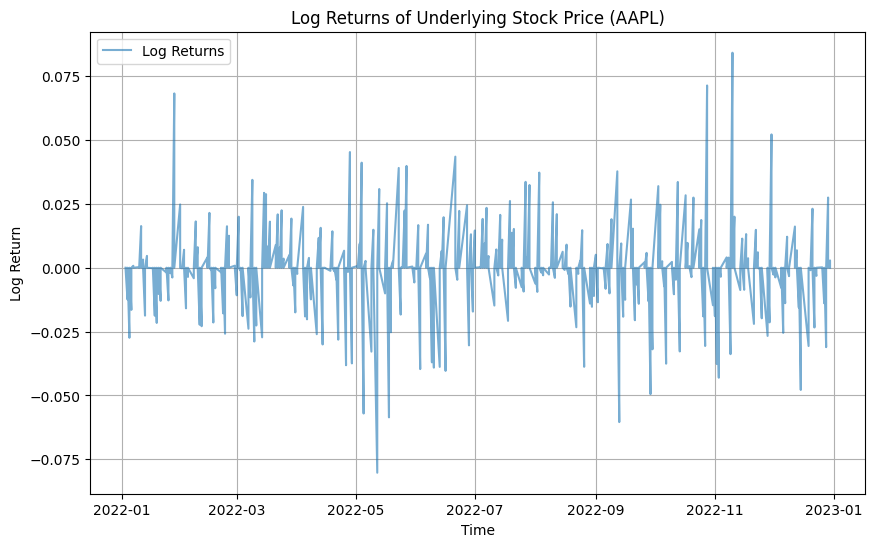

In [10]:
# Plot the log returns (optional visualization)
if len(data) > 0:
    try:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 6))
        plt.plot(data['Time'], data['log_return'], label='Log Returns', alpha=0.6)
        plt.title('Log Returns of Underlying Stock Price (AAPL)')
        plt.xlabel('Time')
        plt.ylabel('Log Return')
        plt.legend()
        plt.grid(True)
        plt.show()
    except Exception as e:
        print(f"Could not plot: {e}")


In [11]:
# Display summary statistics
if len(data) > 0:
    print("\n" + "="*60)
    print("DATA SUMMARY")
    print("="*60)
    print(f"Total rows: {len(data):,}")
    print(f"Date range: {data['Time'].min()} to {data['Time'].max()}")
    print(f"\nKey columns:")
    print(f"  - underlying_stockprice: {data['underlying_stockprice'].min():.2f} to {data['underlying_stockprice'].max():.2f}")
    print(f"  - option_price: {data['option_price'].min():.2f} to {data['option_price'].max():.2f}")
    print(f"  - IV: {data['IV'].min():.4f} to {data['IV'].max():.4f}")
    print(f"  - Maturity: {data['Maturity'].min():.4f} to {data['Maturity'].max():.4f} years")
    print(f"  - C/S: {data['C/S'].min():.4f} to {data['C/S'].max():.4f}")
    print(f"  - K/S: {data['K/S'].min():.4f} to {data['K/S'].max():.4f}")
    print("\n✓ Data is ready for saving!")



DATA SUMMARY
Total rows: 101,257
Date range: 2022-01-03 00:00:00 to 2022-12-30 00:00:00

Key columns:
  - underlying_stockprice: 126.06 to 181.96
  - option_price: 0.10 to 149.10
  - IV: 0.0000 to 0.1759
  - Maturity: 0.0040 to 2.3970 years
  - C/S: 0.0005 to 0.9021
  - K/S: 0.1472 to 2.5385

✓ Data is ready for saving!


In [12]:
# Display sample of cleaned data
if len(data) > 0:
    print("\n" + "="*60)
    print("SAMPLE OF CLEANED DATA (first 5 rows)")
    print("="*60)
    print(data[['Time', 'underlying_stockprice', 'option_price', 'Strike', 'IV', 'Maturity', 'C/S', 'K/S', 'r']].head())



SAMPLE OF CLEANED DATA (first 5 rows)
             Time  underlying_stockprice  option_price  Strike        IV  \
138976 2022-01-03                 181.96         57.45   125.0  0.003697   
138977 2022-01-03                 181.96         63.55   120.0  0.003828   
138978 2022-01-03                 181.96         40.25   145.0  0.003243   
138979 2022-01-03                 181.96         32.40   155.0  0.003069   
138980 2022-01-03                 181.96         35.80   150.0  0.003154   

        Maturity       C/S       K/S       r  
138976  0.765714  0.315729  0.686964  0.0516  
138977  0.765714  0.349253  0.659486  0.0516  
138978  0.765714  0.221202  0.796878  0.0516  
138979  0.765714  0.178061  0.851836  0.0516  
138980  0.765714  0.196747  0.824357  0.0516  


## 5. Save Cleaned Data as combine.csv

Save the processed data for future use, matching the original notebook's workflow.


In [13]:
# Save cleaned and processed data to combine.csv
if len(data) > 0:
    data.to_csv('combine.csv', index=False)
    print("\n" + "="*60)
    print("✓ SUCCESS! Data saved to combine.csv")
    print("="*60)
    print(f"✓ Final dataset shape: {data.shape}")
    print(f"✓ Total rows: {len(data):,}")
    print(f"\n✓ Columns in saved data ({len(data.columns)}):")
    for i, col in enumerate(data.columns.tolist(), 1):
        print(f"  {i:2d}. {col}")
    print("\n" + "="*60)
    print("✓ You can now copy this notebook and continue with model training!")
    print("="*60)
else:
    print("\n✗ ERROR: Cannot save - no data available!")



✓ SUCCESS! Data saved to combine.csv
✓ Final dataset shape: (101257, 14)
✓ Total rows: 101,257

✓ Columns in saved data (14):
   1. underlying_stockprice
   2. option_price
   3. Strike
   4. Volume
   5. Time
   6. IV
   7. DTE
   8. Maturity
   9. r
  10. C/S
  11. K/S
  12. Monyness
  13. log_return
  14. cond_vol

✓ You can now copy this notebook and continue with model training!


In [14]:
# Final verification - display data info
if len(data) > 0:
    print("\nFinal Data Verification:")
    print(f"✓ Shape: {data.shape}")
    print(f"✓ Memory usage: {data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print(f"✓ Missing values per column:")
    missing = data.isnull().sum()
    for col, count in missing[missing > 0].items():
        print(f"    {col}: {count}")
    if missing.sum() == 0:
        print("    ✓ No missing values!")
    
    print(f"\n✓ Data types:")
    print(data.dtypes)
else:
    print("No data to verify!")



Final Data Verification:
✓ Shape: (101257, 14)
✓ Memory usage: 11.59 MB
✓ Missing values per column:
    ✓ No missing values!

✓ Data types:
underlying_stockprice           float64
option_price                    float64
Strike                          float64
Volume                          float64
Time                     datetime64[ns]
IV                              float64
DTE                             float64
Maturity                        float64
r                               float64
C/S                             float64
K/S                             float64
Monyness                        float64
log_return                      float64
cond_vol                        float64
dtype: object


## 6. Multi-Layer Perceptron (MLP) Model

### Model Architecture
| Layer    | Neurons | Activation | Purpose                                   |
| -------- | ------- | ---------- | ----------------------------------------- |
| Input    | 4       | —          | Input features: IV, K/S, Maturity, r     |
| Hidden 1 | 30      | LeakyReLU  | Basic feature extraction                  |
| Hidden 2 | 60      | ELU        | Deeper non-linear relationship            |
| Hidden 3 | 90      | LeakyReLU  | Learn higher-order interactions           |
| Output   | 1       | Linear     | Predict option price ratio (C/S)          |

### Activation Functions
- **LeakyReLU**: Prevents dead neurons by allowing small negative gradients
- **ELU**: Provides smooth transitions and better gradient flow


In [15]:
# Define the feature columns and the target column
feature_columns = ['IV', 'K/S', 'Maturity', 'r']
target_column = 'C/S'

# Split the data into features and target
X = data[feature_columns]
y = data[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting datasets
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Test target shape: {y_test.shape}")


Training set shape: (81005, 4)
Test set shape: (20252, 4)
Training target shape: (81005,)
Test target shape: (20252,)


In [16]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [17]:
# Create MLP model (same architecture as original notebook)
model_ML = Sequential()

model_ML.add(Dense(30, input_dim=4))
model_ML.add(LeakyReLU())
model_ML.add(Dense(60))
model_ML.add(ELU())
model_ML.add(Dense(90))
model_ML.add(LeakyReLU())
model_ML.add(Dense(1))

# Compile the model
model_ML.compile(loss='mean_squared_error', optimizer='adam')

print("MLP Model Architecture:")
model_ML.summary()


MLP Model Architecture:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                150       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 30)                0         
                                                                 
 dense_1 (Dense)             (None, 60)                1860      
                                                                 
 elu (ELU)                   (None, 60)                0         
                                                                 
 dense_2 (Dense)             (None, 90)                5490      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 90)                0         
                                                                 
 dense_3 (Dense)             (No

In [18]:
# Train the model
ML_prediction_start_time = time.time()
history_model_ML = model_ML.fit(X_train, y_train, epochs=100, batch_size=15, verbose=0)
ML_prediction_end_time = time.time()
ML_prediction_time = ML_prediction_end_time - ML_prediction_start_time

print(f"Training time: {ML_prediction_time:.2f} seconds")


Training time: 201.23 seconds


In [19]:
# Make predictions
y_pred_ML = model_ML.predict(X_test)

# Calculate evaluation metrics
rmse_ML = np.sqrt(mean_squared_error(y_test, y_pred_ML))
mae_ML = mean_absolute_error(y_test, y_pred_ML)
mse_ML = mean_squared_error(y_test, y_pred_ML)
r2_ML = r2_score(y_test, y_pred_ML)

print("MLP Model Performance Metrics:")
print(f"   R-squared: {r2_ML:.6f}")
print(f"   RMSE: {rmse_ML:.10f}")
print(f"   MAE: {mae_ML:.10f}")
print(f"   MSE: {mse_ML:.10f}")


633/633 [==============================] - 0s 248us/step
MLP Model Performance Metrics:
   R-squared: 0.997207
   RMSE: 0.0077752369
   MAE: 0.0043189887
   MSE: 0.0000604543


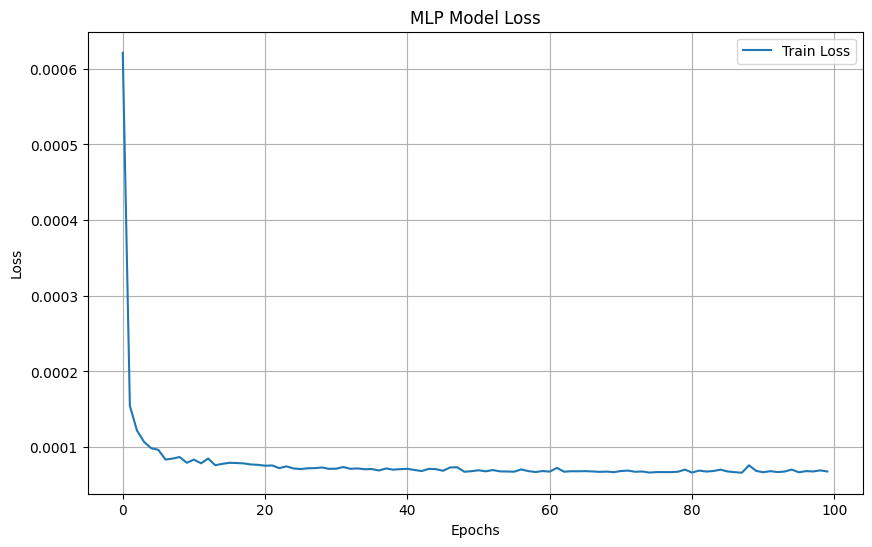

In [20]:
# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(history_model_ML.history['loss'], label='Train Loss')
plt.title('MLP Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


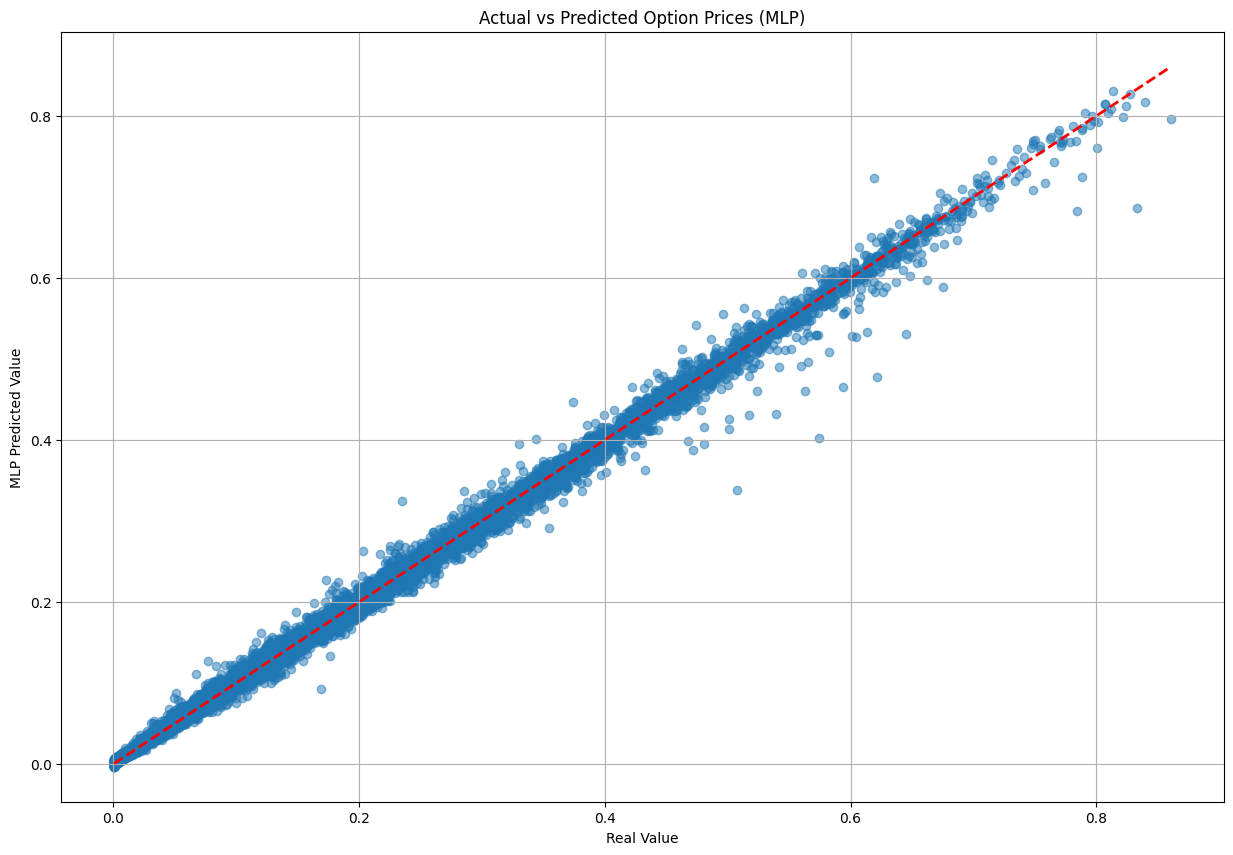

In [21]:
# Comparison of real values and predictions on the test dataset
plt.figure(figsize=(15, 10))
plt.scatter(y_test, y_pred_ML, alpha=0.5)
plt.xlabel("Real Value")
plt.ylabel("MLP Predicted Value")
plt.title('Actual vs Predicted Option Prices (MLP)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.grid(True)
plt.show()


Fraction Statistics (Predicted/Actual - 1):
Min: -6.89598722755909
Max: 8.22970265224576
Mean: 0.05530551909043963
Std: 0.48468086914691777


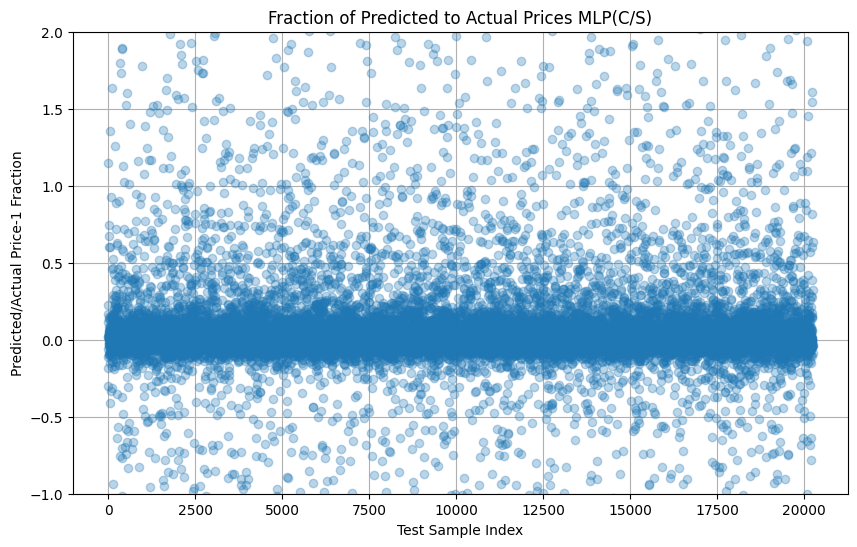

In [22]:
# Calculate prediction fractions
y_test_reset = y_test.reset_index(drop=True)
y_pred_ML_flat = y_pred_ML.flatten()
frac_ML = pd.DataFrame({'Actual': y_test_reset, 'Predicted': y_pred_ML_flat})

y_testf = frac_ML['Actual'].values
y_predf = frac_ML['Predicted'].values

# Calculate the fractions
fractionsf = y_predf / y_testf - 1

# Print statistics for fractions
print("Fraction Statistics (Predicted/Actual - 1):")
print("Min:", np.min(fractionsf))
print("Max:", np.max(fractionsf))
print("Mean:", np.mean(fractionsf))
print("Std:", np.std(fractionsf))

# Plot the fractions
plt.figure(figsize=(10, 6))
plt.plot(fractionsf, 'o', alpha=0.3)
plt.xlabel('Test Sample Index')
plt.ylabel('Predicted/Actual Price-1 Fraction')
plt.title('Fraction of Predicted to Actual Prices MLP(C/S)')
plt.ylim(-1, 2)
plt.grid(True)
plt.show()


## 7. MLP Model with Log-Transformed Target

Using log-transformed target variable (log(C/S)) can help with skewed distributions and improve model performance.


In [23]:
# Use log-transformed target
feature_columns = ['IV', 'K/S', 'Maturity', 'r']
target_column = 'C/S'

# Split the data into features and target
X = data[feature_columns]
y = log(data[target_column])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")


Training set shape: (81005, 4)
Test set shape: (20252, 4)


In [24]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [25]:
# Create MLP model for log-transformed target
model_ML_log = Sequential()

model_ML_log.add(Dense(30, input_dim=4))
model_ML_log.add(LeakyReLU())
model_ML_log.add(Dense(60))
model_ML_log.add(ELU())
model_ML_log.add(Dense(90))
model_ML_log.add(LeakyReLU())
model_ML_log.add(Dense(1))

# Compile the model
model_ML_log.compile(loss='mean_squared_error', optimizer='adam')


In [26]:
# Train the model
ML_prediction_start_time = time.time()
history_model_ML_log = model_ML_log.fit(X_train, y_train, epochs=100, batch_size=15, verbose=0)
ML_prediction_end_time = time.time()
ML_prediction_time_log = ML_prediction_end_time - ML_prediction_start_time

print(f"Training time: {ML_prediction_time_log:.2f} seconds")


Training time: 204.69 seconds


In [27]:
# Make predictions (in log space)
y_pred_ML_log = model_ML_log.predict(X_test)

# Calculate evaluation metrics
rmse_ML_log = np.sqrt(mean_squared_error(y_test, y_pred_ML_log))
mae_ML_log = mean_absolute_error(y_test, y_pred_ML_log)
mse_ML_log = mean_squared_error(y_test, y_pred_ML_log)
r2_ML_log = r2_score(y_test, y_pred_ML_log)

print("MLP Model Performance Metrics (Log-Transformed):")
print(f"   R-squared: {r2_ML_log:.6f}")
print(f"   RMSE: {rmse_ML_log:.10f}")
print(f"   MAE: {mae_ML_log:.10f}")
print(f"   MSE: {mse_ML_log:.10f}")


633/633 [==============================] - 0s 234us/step
MLP Model Performance Metrics (Log-Transformed):
   R-squared: 0.997390
   RMSE: 0.0903813609
   MAE: 0.0624349812
   MSE: 0.0081687904


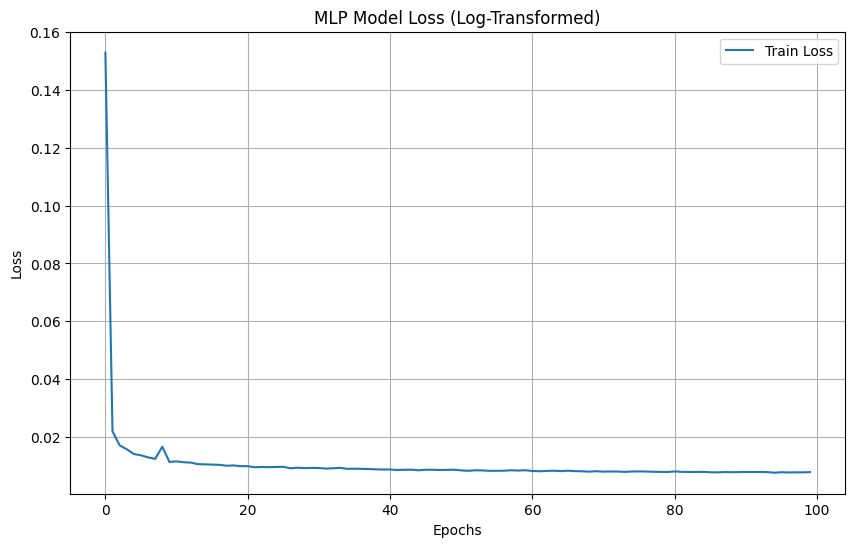

In [28]:
# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(history_model_ML_log.history['loss'], label='Train Loss')
plt.title('MLP Model Loss (Log-Transformed)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


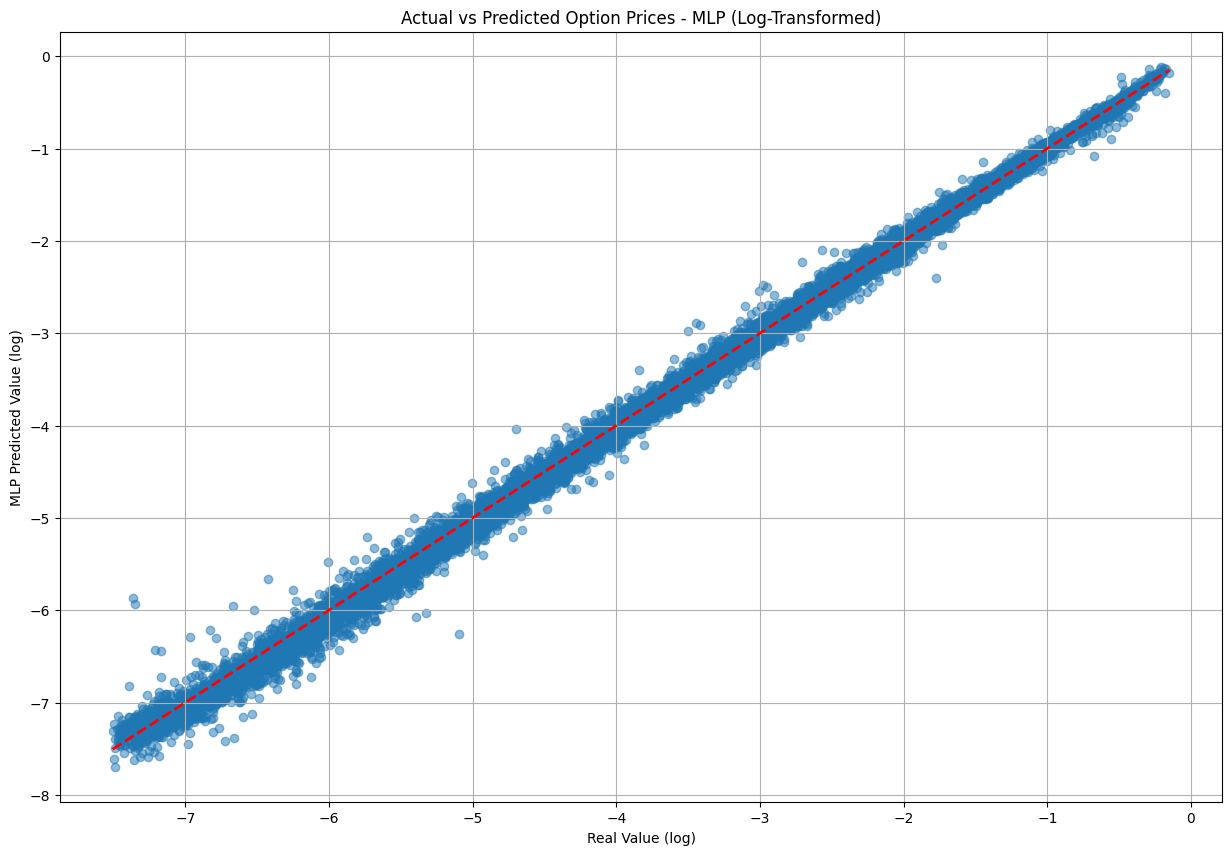

In [29]:
# Comparison of real values and predictions
plt.figure(figsize=(15, 10))
plt.scatter(y_test, y_pred_ML_log, alpha=0.5)
plt.xlabel("Real Value (log)")
plt.ylabel("MLP Predicted Value (log)")
plt.title('Actual vs Predicted Option Prices - MLP (Log-Transformed)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.grid(True)
plt.show()


## 8. LSTM Model

Long Short-Term Memory (LSTM) networks are designed to capture temporal dependencies in sequential data, making them suitable for time-series option pricing.


In [30]:
# Define feature columns and target
feature_columns = ['IV', 'K/S', 'Maturity', 'r']
target_column = 'C/S'

# Split the data into features and target
X = data[feature_columns]
y = data[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the data for LSTM (samples, timesteps, features)
X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print(f"LSTM Training shape: {X_train_lstm.shape}")
print(f"LSTM Test shape: {X_test_lstm.shape}")


LSTM Training shape: (81005, 1, 4)
LSTM Test shape: (20252, 1, 4)


In [31]:
# Create LSTM model function
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(1, 4)))
    model.add(LSTM(units=100, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(units=50, activation='elu'))
    model.add(Dense(units=1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

lstm_model = create_lstm_model()
print("LSTM Model Architecture:")
lstm_model.summary()


LSTM Model Architecture:
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 100)            42000     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_8 (Dense)             (None, 50)                5050      
                                                                 
 dense_9 (Dense)             (None, 1)                 51        
                                                                 
Total params: 127501 (498.05 KB)
Trainable params: 127501 (498.05 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________________________________________

In [32]:
# Train the LSTM model
lstm_start_time = time.time()
lstm_history = lstm_model.fit(X_train_lstm, y_train, epochs=150, batch_size=16, verbose=0)
lstm_end_time = time.time()
lstm_training_time = lstm_end_time - lstm_start_time

print(f"LSTM Training time: {lstm_training_time:.2f} seconds")


LSTM Training time: 786.17 seconds


In [33]:
# Evaluate the model
train_loss = lstm_model.evaluate(X_train_lstm, y_train, verbose=0)
test_loss = lstm_model.evaluate(X_test_lstm, y_test, verbose=0)

print(f'Train Loss: {train_loss:.10f}')
print(f'Test Loss: {test_loss:.10f}')

# Make predictions
y_pred_lstm = lstm_model.predict(X_test_lstm)

# Calculate evaluation metrics
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm)

print(f"\nLSTM Model Performance Metrics:")
print(f"   R-squared: {r2_lstm:.6f}")
print(f"   RMSE: {rmse_lstm:.10f}")
print(f"   MAE: {mae_lstm:.10f}")
print(f"   MSE: {mse_lstm:.10f}")


Train Loss: 0.0000572441
Test Loss: 0.0000583859
633/633 [==============================] - 1s 519us/step

LSTM Model Performance Metrics:
   R-squared: 0.997303
   RMSE: 0.0076410640
   MAE: 0.0039826462
   MSE: 0.0000583859


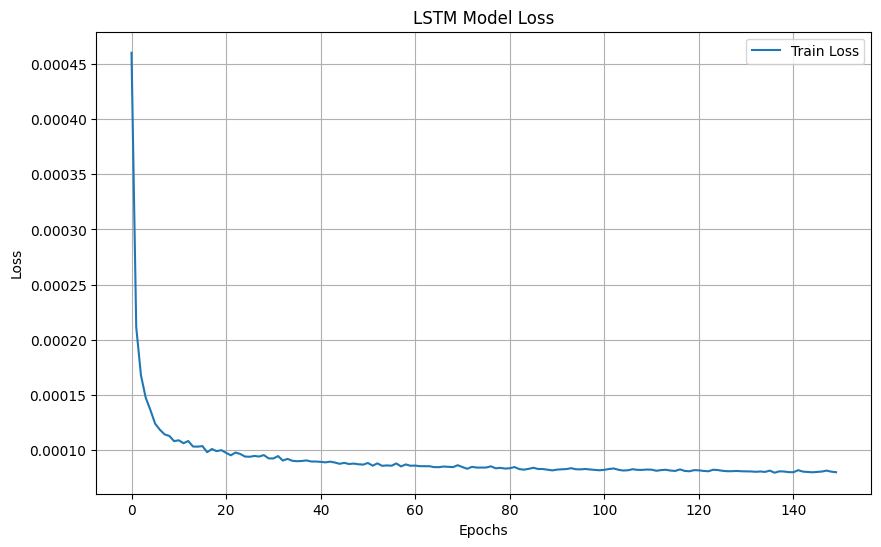

In [34]:
# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(lstm_history.history['loss'], label='Train Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


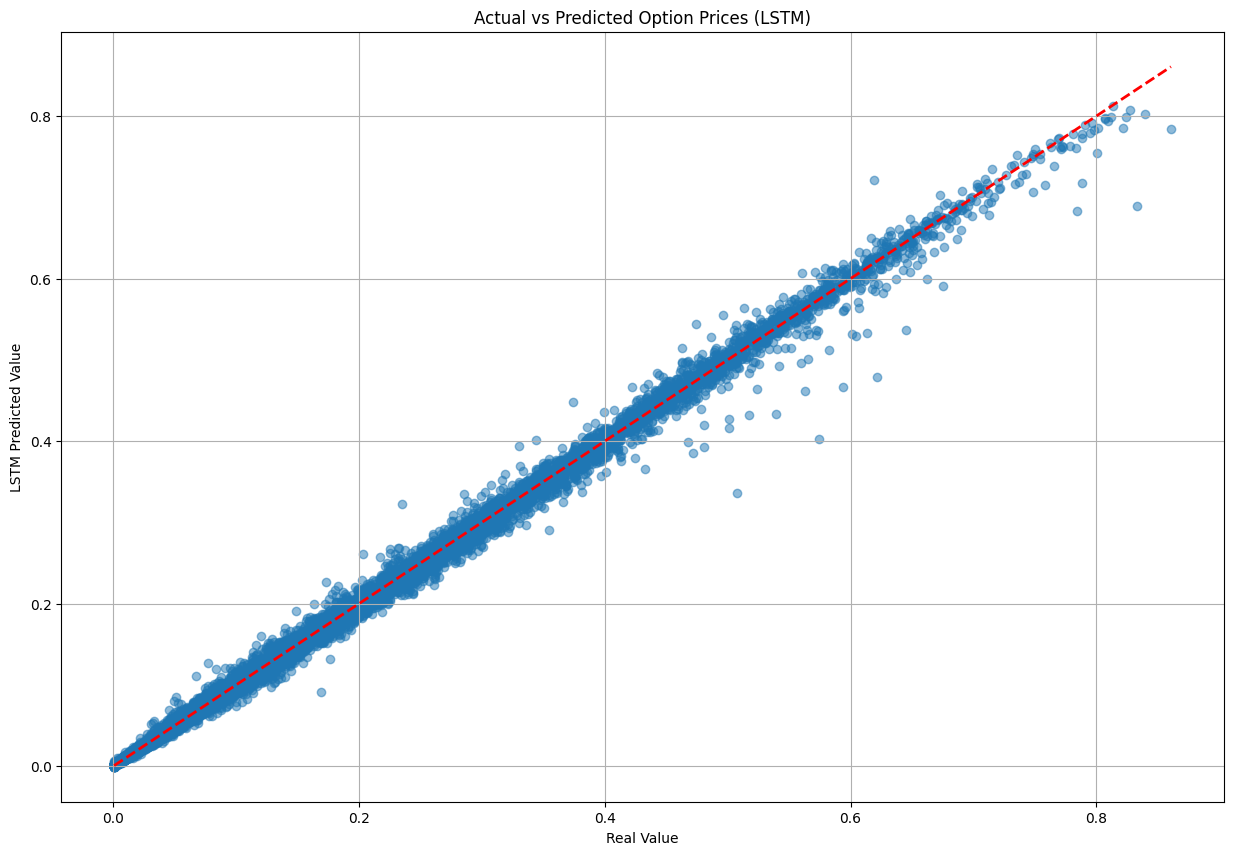

In [35]:
# Plot LSTM results
plt.figure(figsize=(15, 10))
plt.scatter(y_test, y_pred_lstm, alpha=0.5)
plt.xlabel("Real Value")
plt.ylabel("LSTM Predicted Value")
plt.title('Actual vs Predicted Option Prices (LSTM)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.grid(True)
plt.show()


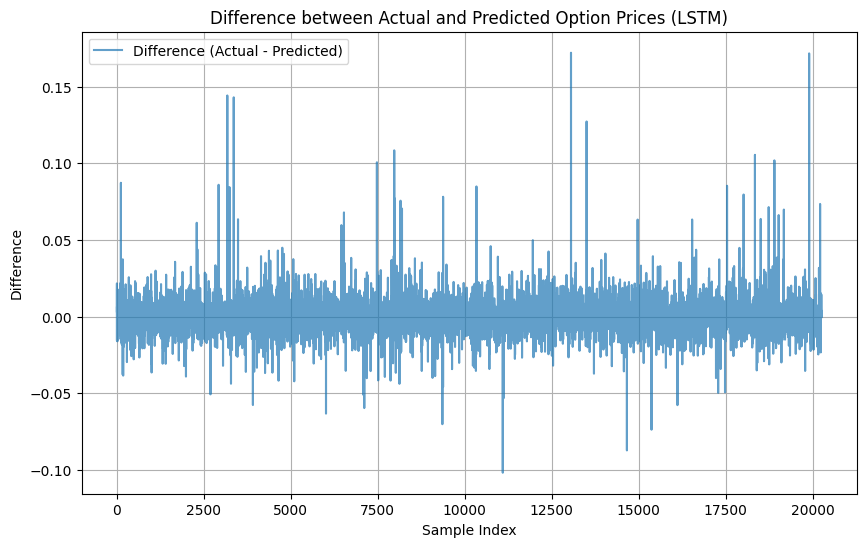

In [36]:
# Calculate difference
difference = y_test.values - y_pred_lstm.flatten()

# Plot the difference
plt.figure(figsize=(10, 6))
plt.plot(difference, label='Difference (Actual - Predicted)', alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('Difference')
plt.title('Difference between Actual and Predicted Option Prices (LSTM)')
plt.legend()
plt.grid(True)
plt.show()


In [37]:
# Use log-transformed target
feature_columns = ['IV', 'K/S', 'Maturity', 'r']
target_column = 'C/S'

# Split the data into features and target
X = data[feature_columns]
y = log(data[target_column])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the data for LSTM
X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))


In [38]:
# Create and train LSTM model for log-transformed target
lstm_model_log = create_lstm_model()
lstm_start_time = time.time()
lstm_history_log = lstm_model_log.fit(X_train_lstm, y_train, epochs=150, batch_size=16, verbose=0)
lstm_end_time = time.time()
lstm_training_time_log = lstm_end_time - lstm_start_time

print(f"LSTM Training time (log): {lstm_training_time_log:.2f} seconds")


LSTM Training time (log): 821.22 seconds


In [39]:
# Make predictions
y_pred_lstm_log = lstm_model_log.predict(X_test_lstm)

# Calculate evaluation metrics
rmse_lstm_log = np.sqrt(mean_squared_error(y_test, y_pred_lstm_log))
mae_lstm_log = mean_absolute_error(y_test, y_pred_lstm_log)
mse_lstm_log = mean_squared_error(y_test, y_pred_lstm_log)
r2_lstm_log = r2_score(y_test, y_pred_lstm_log)

print(f"LSTM Model Performance Metrics (Log-Transformed):")
print(f"   R-squared: {r2_lstm_log:.6f}")
print(f"   RMSE: {rmse_lstm_log:.10f}")
print(f"   MAE: {mae_lstm_log:.10f}")
print(f"   MSE: {mse_lstm_log:.10f}")


633/633 [==============================] - 1s 513us/step
LSTM Model Performance Metrics (Log-Transformed):
   R-squared: 0.856725
   RMSE: 0.6696446907
   MAE: 0.6224181024
   MSE: 0.4484240118


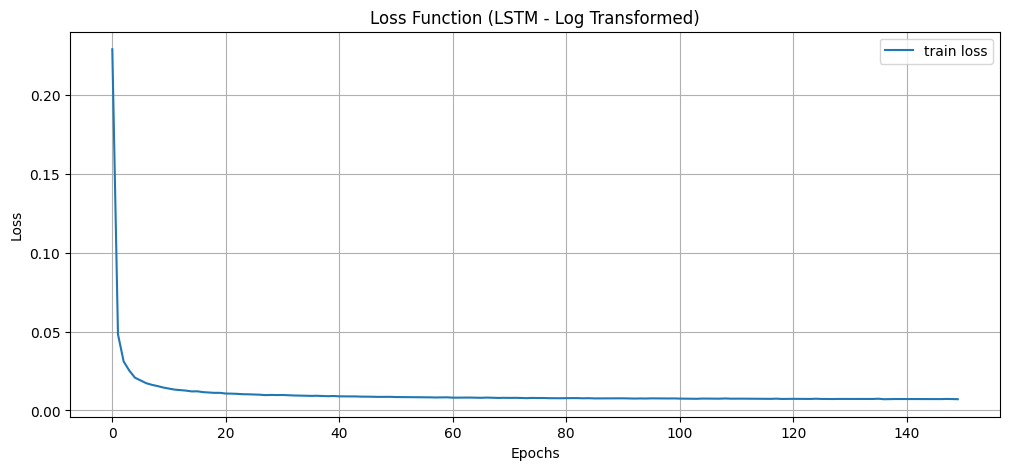

In [40]:
# Plot the loss
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(lstm_history_log.history["loss"], label="train loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Loss Function (LSTM - Log Transformed)')
ax.legend()
plt.grid(True)
plt.show()


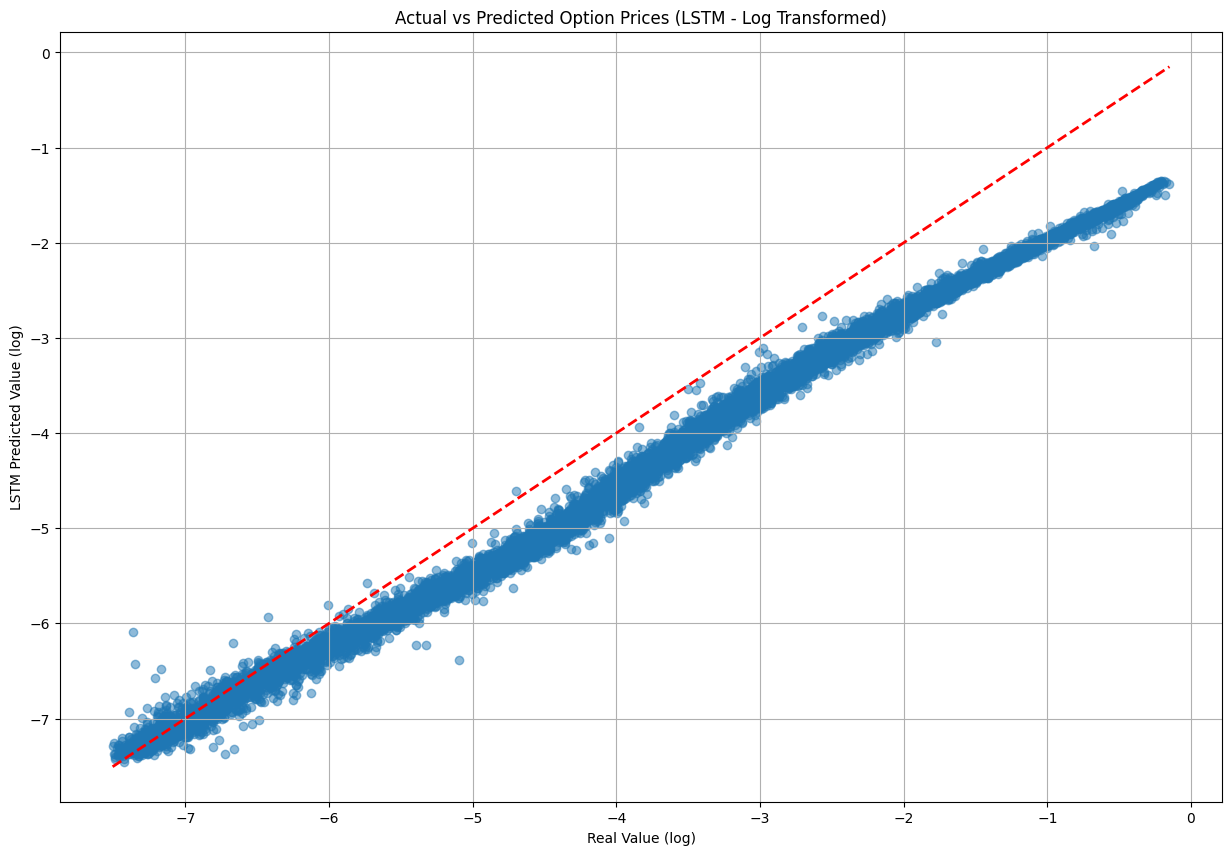

In [41]:
# Plot LSTM results
plt.figure(figsize=(15, 10))
plt.scatter(y_test, y_pred_lstm_log, alpha=0.5)
plt.xlabel("Real Value (log)")
plt.ylabel("LSTM Predicted Value (log)")
plt.title('Actual vs Predicted Option Prices (LSTM - Log Transformed)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.grid(True)
plt.show()


In [42]:
# Define feature columns and target
feature_columns = ['IV', 'K/S', 'Maturity', 'r']
target_column = 'C/S'

# Split the data into features and target
X = data[feature_columns]
y = data[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the data for GRU
X_train_gru = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_gru = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))


In [43]:
# Create GRU model function
def create_gru_model():
    model = Sequential()
    model.add(GRU(units=100, return_sequences=True, input_shape=(1, 4)))
    model.add(GRU(units=100, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(units=50, activation='elu'))
    model.add(Dense(units=1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

gru_model = create_gru_model()
print("GRU Model Architecture:")
gru_model.summary()


GRU Model Architecture:
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1, 100)            31800     
                                                                 
 gru_1 (GRU)                 (None, 100)               60600     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_12 (Dense)            (None, 50)                5050      
                                                                 
 dense_13 (Dense)            (None, 1)                 51        
                                                                 
Total params: 97501 (380.86 KB)
Trainable params: 97501 (380.86 KB)
Non-trainable params: 0 (0.00 Byte)
__________________________________________________________

In [44]:
# Train the GRU model
gru_start_time = time.time()
gru_history = gru_model.fit(X_train_gru, y_train, epochs=200, batch_size=32, verbose=0)
gru_end_time = time.time()
gru_training_time = gru_end_time - gru_start_time

print(f'GRU Training time: {gru_training_time:.2f} seconds')


GRU Training time: 585.98 seconds


In [45]:
# Make predictions
y_pred_gru = gru_model.predict(X_test_gru)

# Calculate evaluation metrics
rmse_gru = np.sqrt(mean_squared_error(y_test, y_pred_gru))
mae_gru = mean_absolute_error(y_test, y_pred_gru)
mse_gru = mean_squared_error(y_test, y_pred_gru)
r2_gru = r2_score(y_test, y_pred_gru)

print(f"GRU Model Performance Metrics:")
print(f"   R-squared: {r2_gru:.6f}")
print(f"   RMSE: {rmse_gru:.10f}")
print(f"   MAE: {mae_gru:.10f}")
print(f"   MSE: {mse_gru:.10f}")


633/633 [==============================] - 1s 465us/step
GRU Model Performance Metrics:
   R-squared: 0.997195
   RMSE: 0.0077927806
   MAE: 0.0042443341
   MSE: 0.0000607274


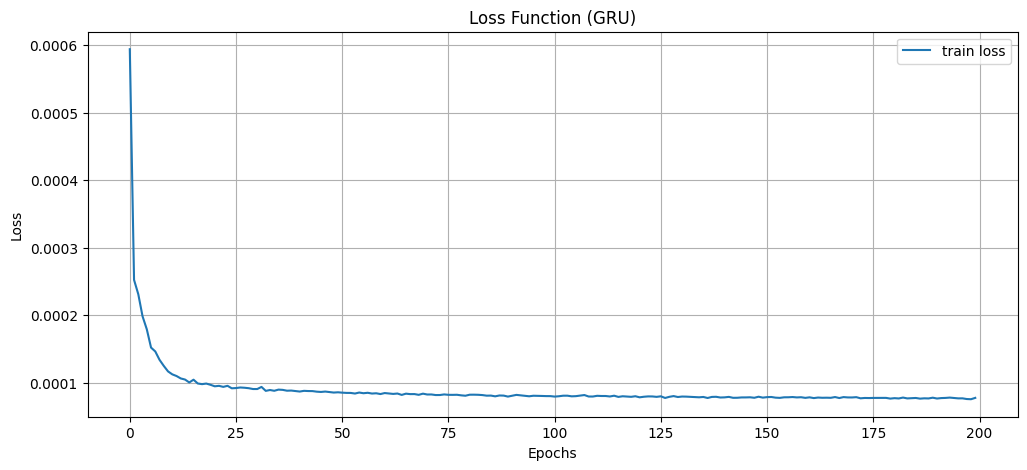

In [46]:
# Plot the loss
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(gru_history.history["loss"], label="train loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Loss Function (GRU)')
ax.legend()
plt.grid(True)
plt.show()


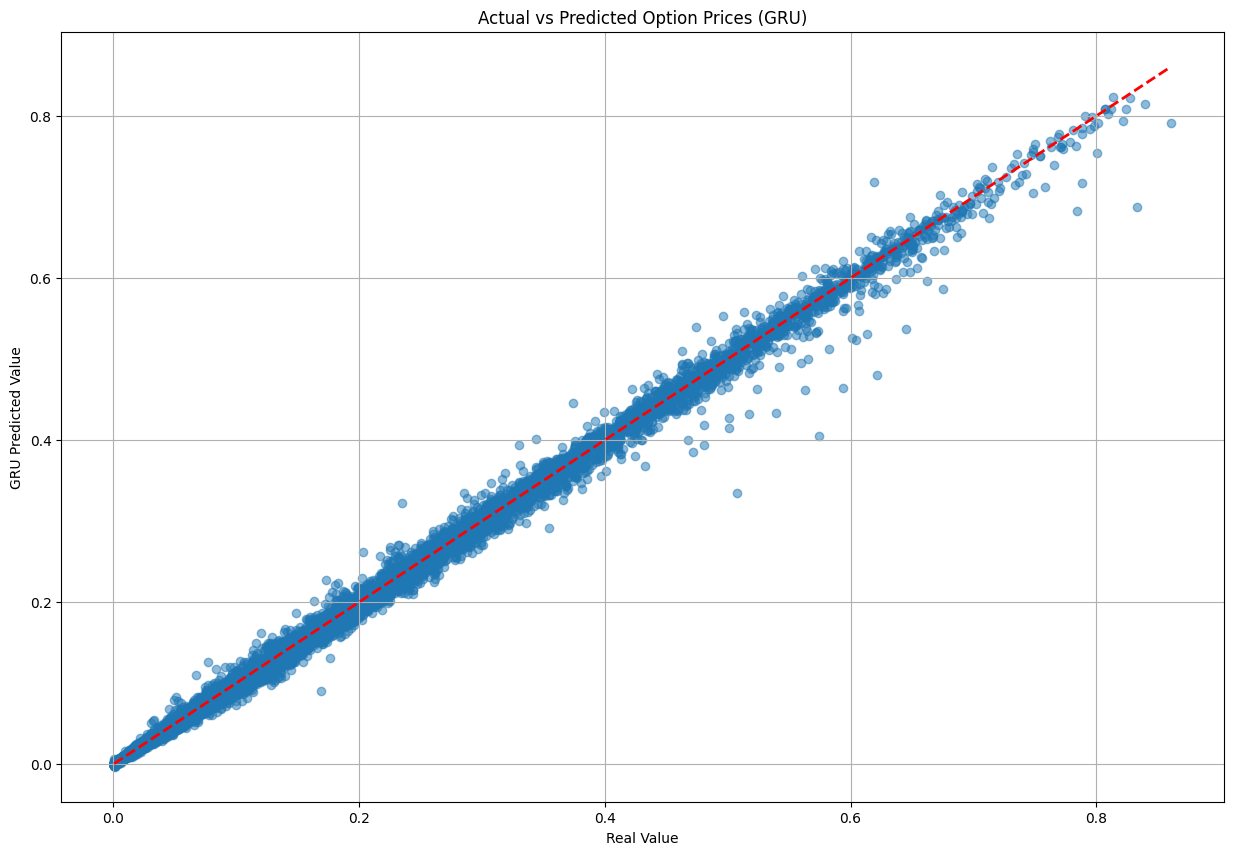

In [47]:
# Plot GRU results
plt.figure(figsize=(15, 10))
plt.scatter(y_test, y_pred_gru, alpha=0.5)
plt.xlabel("Real Value")
plt.ylabel("GRU Predicted Value")
plt.title('Actual vs Predicted Option Prices (GRU)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.grid(True)
plt.show()


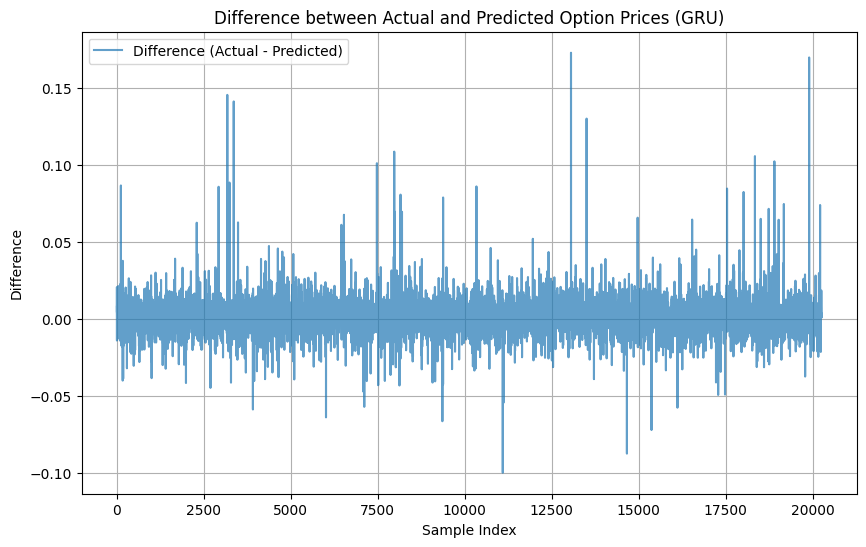

In [48]:
# Calculate difference
difference = y_test.values - y_pred_gru.flatten()

# Plot the difference
plt.figure(figsize=(10, 6))
plt.plot(difference, label='Difference (Actual - Predicted)', alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('Difference')
plt.title('Difference between Actual and Predicted Option Prices (GRU)')
plt.legend()
plt.grid(True)
plt.show()


## 11. GRU Model with Log-Transformed Target


In [49]:
# Use log-transformed target
feature_columns = ['IV', 'K/S', 'Maturity', 'r']
target_column = 'C/S'

# Split the data into features and target
X = data[feature_columns]
y = log(data[target_column])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the data for GRU
X_train_gru = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_gru = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))


In [50]:
# Create and train GRU model for log-transformed target
gru_model_log = create_gru_model()
gru_start_time = time.time()
gru_history_log = gru_model_log.fit(X_train_gru, y_train, epochs=200, batch_size=32, verbose=0)
gru_end_time = time.time()
gru_training_time_log = gru_end_time - gru_start_time

print(f'GRU Training time (log): {gru_training_time_log:.2f} seconds')


GRU Training time (log): 673.66 seconds


In [51]:
# Make predictions
y_pred_gru_log = gru_model_log.predict(X_test_gru)

# Calculate evaluation metrics
rmse_gru_log = np.sqrt(mean_squared_error(y_test, y_pred_gru_log))
mae_gru_log = mean_absolute_error(y_test, y_pred_gru_log)
mse_gru_log = mean_squared_error(y_test, y_pred_gru_log)
r2_gru_log = r2_score(y_test, y_pred_gru_log)

print(f"GRU Model Performance Metrics (Log-Transformed):")
print(f"   R-squared: {r2_gru_log:.6f}")
print(f"   RMSE: {rmse_gru_log:.10f}")
print(f"   MAE: {mae_gru_log:.10f}")
print(f"   MSE: {mse_gru_log:.10f}")


633/633 [==============================] - 1s 578us/step
GRU Model Performance Metrics (Log-Transformed):
   R-squared: 0.837829
   RMSE: 0.7124359780
   MAE: 0.6173770257
   MSE: 0.5075650228


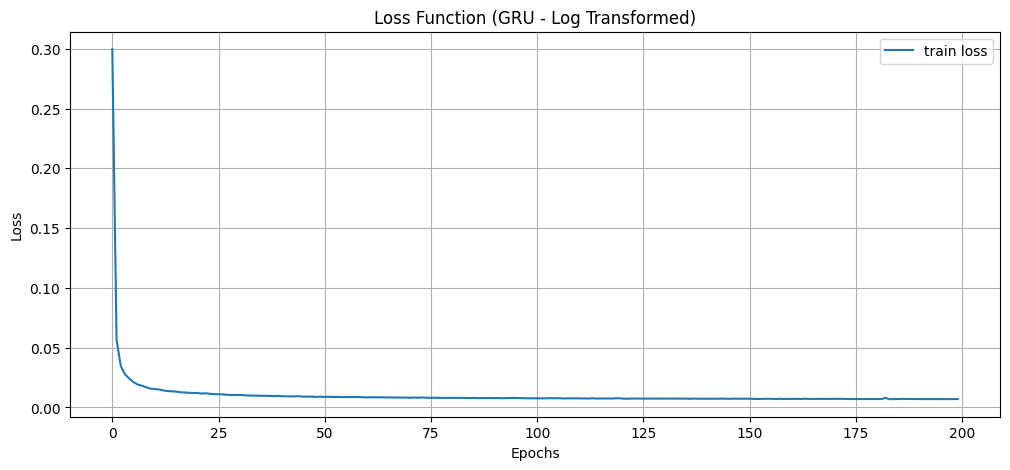

In [52]:
# Plot the loss
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(gru_history_log.history["loss"], label="train loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Loss Function (GRU - Log Transformed)')
ax.legend()
plt.grid(True)
plt.show()


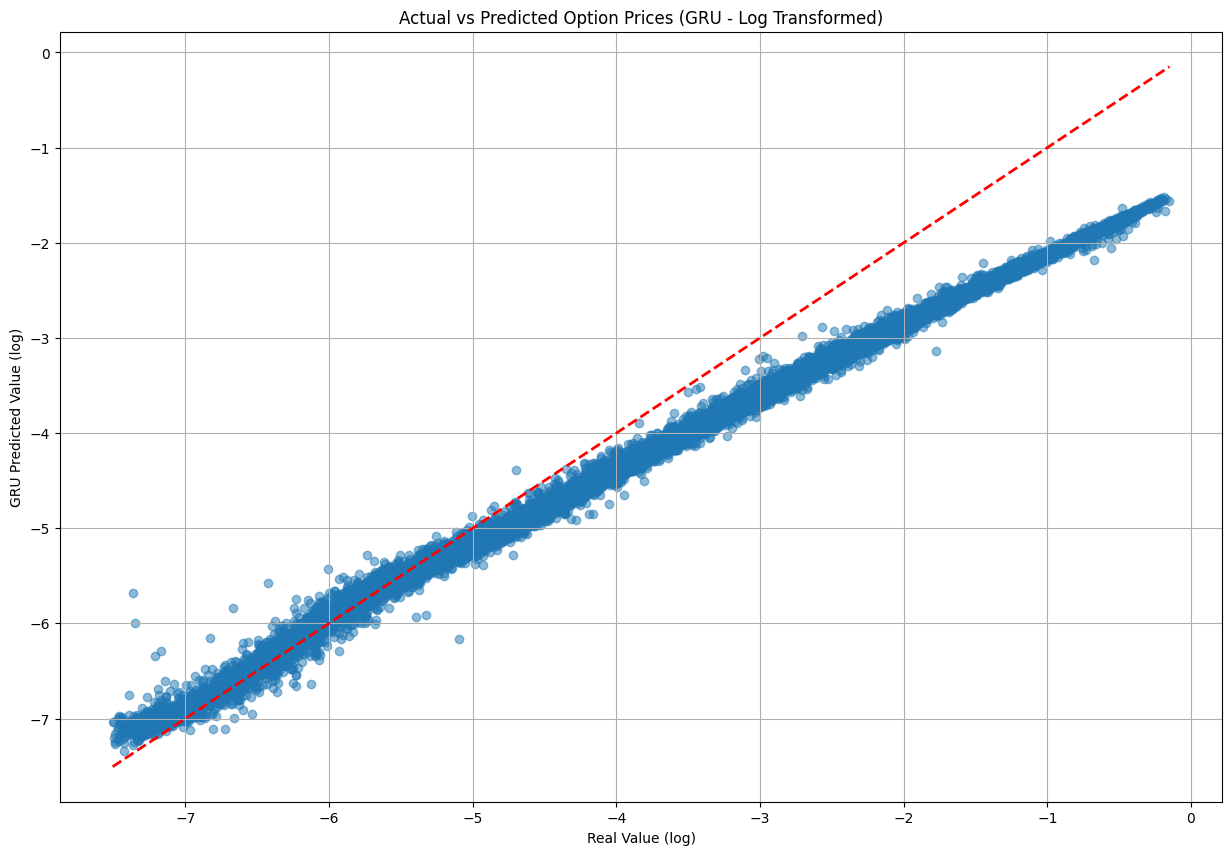

In [53]:
# Plot GRU results
plt.figure(figsize=(15, 10))
plt.scatter(y_test, y_pred_gru_log, alpha=0.5)
plt.xlabel("Real Value (log)")
plt.ylabel("GRU Predicted Value (log)")
plt.title('Actual vs Predicted Option Prices (GRU - Log Transformed)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.grid(True)
plt.show()


## 12. Models with GARCH Conditional Volatility

Adding GARCH conditional volatility as an additional feature to improve model performance.


In [54]:
# Define feature columns including GARCH conditional volatility
feature_columns = ['IV', 'K/S', 'Maturity', 'r', 'cond_vol']
target_column = 'C/S'

# Split the data into features and target
X = data[feature_columns]
y = data[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the data for LSTM/GRU
X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print(f"Training shape: {X_train_lstm.shape}")
print(f"Test shape: {X_test_lstm.shape}")


Training shape: (81005, 1, 5)
Test shape: (20252, 1, 5)


In [55]:
# Create LSTM model with GARCH (5 features)
def create_lstm_model_garch():
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(1, 5)))
    model.add(LSTM(units=100, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(units=50, activation='elu'))
    model.add(Dense(units=1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

lstm_model_garch = create_lstm_model_garch()
lstm_history_garch = lstm_model_garch.fit(X_train_lstm, y_train, epochs=150, batch_size=16, verbose=0)

# Evaluate
train_loss = lstm_model_garch.evaluate(X_train_lstm, y_train, verbose=0)
test_loss = lstm_model_garch.evaluate(X_test_lstm, y_test, verbose=0)

print(f'Train Loss: {train_loss:.10f}')
print(f'Test Loss: {test_loss:.10f}')

# Predictions
y_pred_lstm_garch = lstm_model_garch.predict(X_test_lstm)
rmse_lstm_garch = np.sqrt(mean_squared_error(y_test, y_pred_lstm_garch))
r2_lstm_garch = r2_score(y_test, y_pred_lstm_garch)

print(f"\nLSTM with GARCH Performance:")
print(f"   R-squared: {r2_lstm_garch:.6f}")
print(f"   RMSE: {rmse_lstm_garch:.10f}")


Train Loss: 0.0000576981
Test Loss: 0.0000587716
633/633 [==============================] - 1s 522us/step

LSTM with GARCH Performance:
   R-squared: 0.997285
   RMSE: 0.0076662643


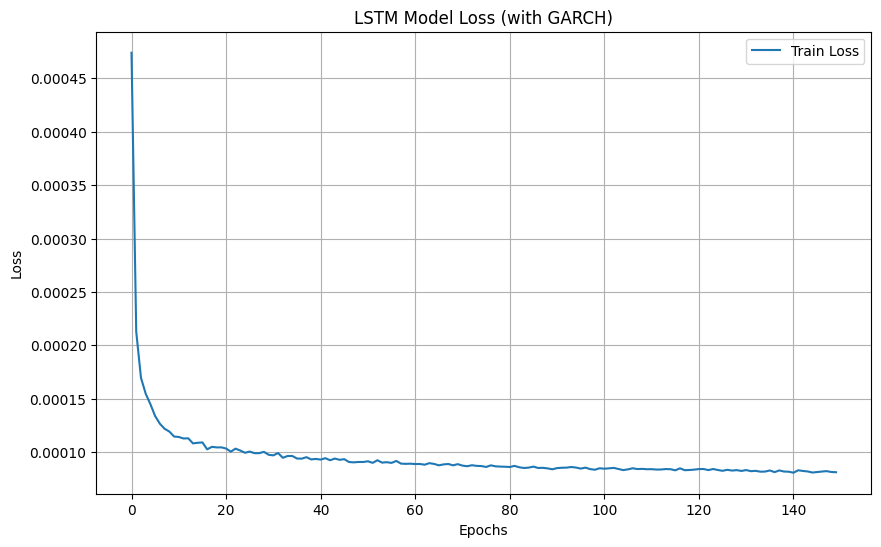

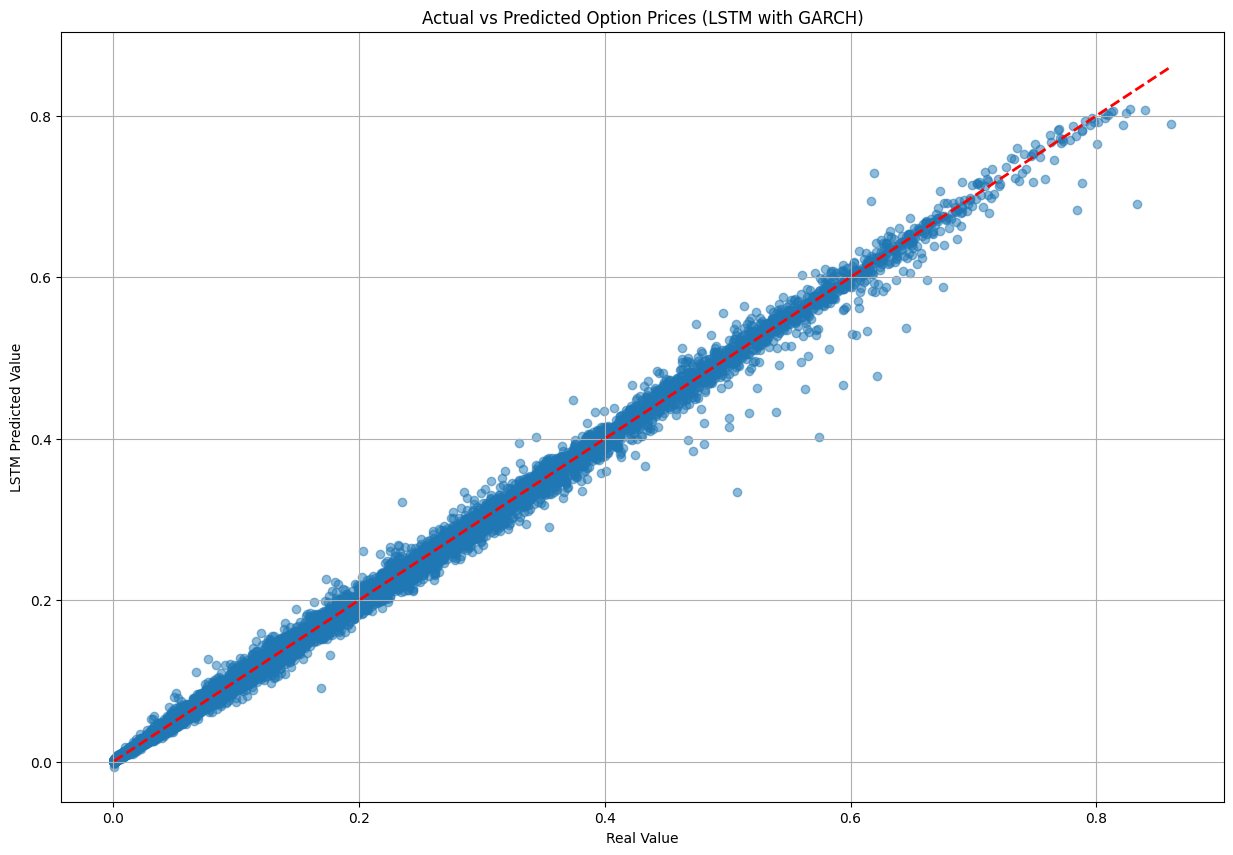

In [56]:
# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(lstm_history_garch.history['loss'], label='Train Loss')
plt.title('LSTM Model Loss (with GARCH)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Comparison plot
plt.figure(figsize=(15, 10))
plt.scatter(y_test, y_pred_lstm_garch, alpha=0.5)
plt.xlabel("Real Value")
plt.ylabel("LSTM Predicted Value")
plt.title('Actual vs Predicted Option Prices (LSTM with GARCH)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.grid(True)
plt.show()


In [57]:
# Create GRU model with GARCH (5 features)
def create_gru_model_garch():
    model = Sequential()
    model.add(GRU(units=100, return_sequences=True, input_shape=(1, 5)))
    model.add(GRU(units=100, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(units=50, activation='elu'))
    model.add(Dense(units=1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

gru_model_garch = create_gru_model_garch()
gru_history_garch = gru_model_garch.fit(X_train_lstm, y_train, epochs=150, batch_size=16, verbose=0)

# Evaluate
train_loss = gru_model_garch.evaluate(X_train_lstm, y_train, verbose=0)
test_loss = gru_model_garch.evaluate(X_test_lstm, y_test, verbose=0)

print(f'Train Loss: {train_loss:.10f}')
print(f'Test Loss: {test_loss:.10f}')

# Predictions
y_pred_gru_garch = gru_model_garch.predict(X_test_lstm)
rmse_gru_garch = np.sqrt(mean_squared_error(y_test, y_pred_gru_garch))
r2_gru_garch = r2_score(y_test, y_pred_gru_garch)

print(f"\nGRU with GARCH Performance:")
print(f"   R-squared: {r2_gru_garch:.6f}")
print(f"   RMSE: {rmse_gru_garch:.10f}")


Train Loss: 0.0000617264
Test Loss: 0.0000624709
633/633 [==============================] - 1s 609us/step

GRU with GARCH Performance:
   R-squared: 0.997114
   RMSE: 0.0079038519


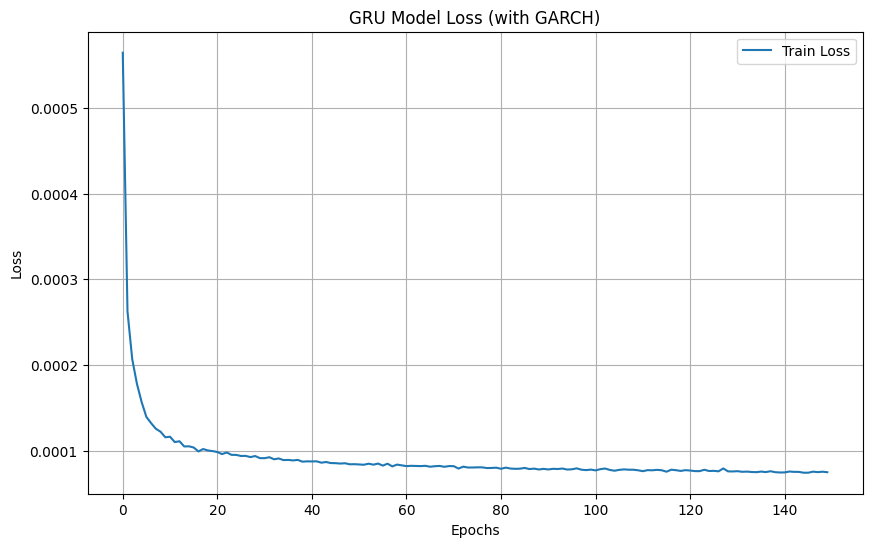

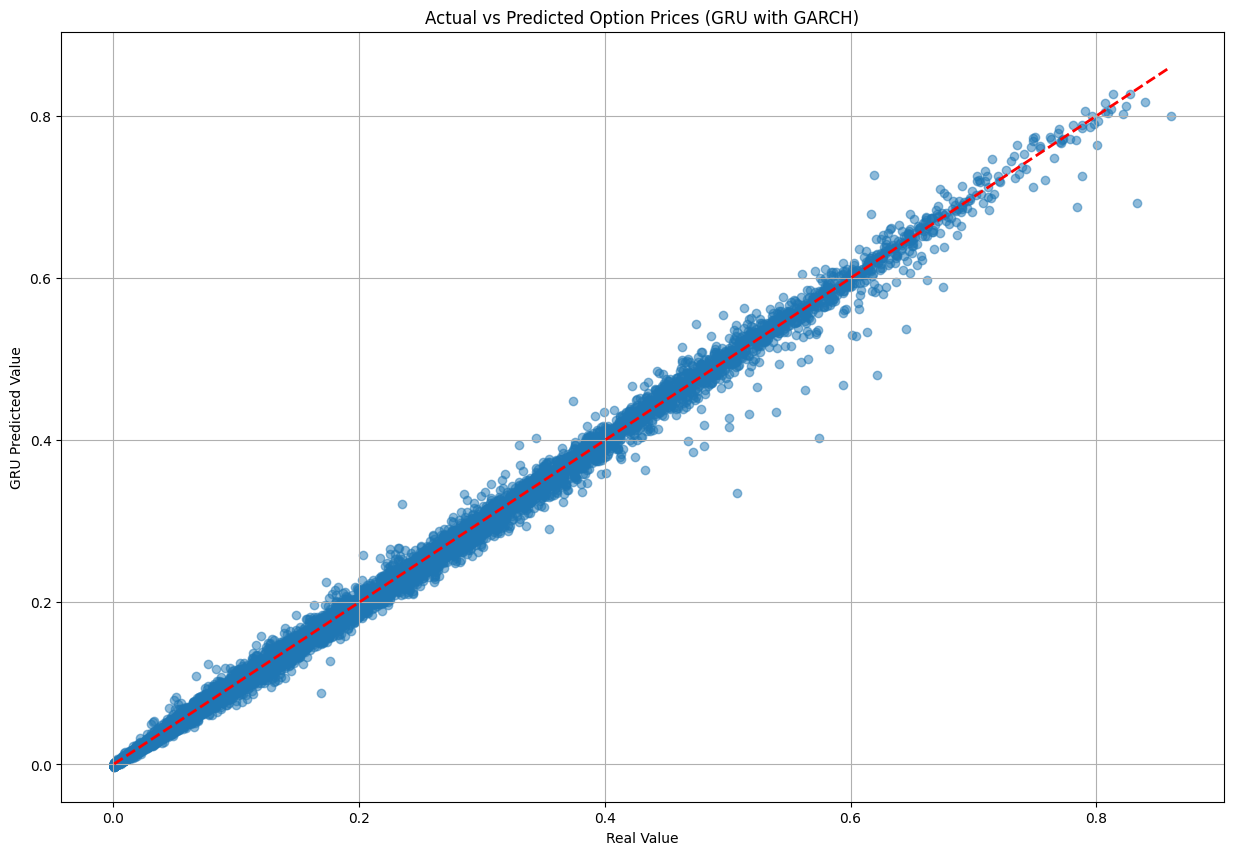

In [58]:
# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(gru_history_garch.history['loss'], label='Train Loss')
plt.title('GRU Model Loss (with GARCH)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Comparison plot
plt.figure(figsize=(15, 10))
plt.scatter(y_test, y_pred_gru_garch, alpha=0.5)
plt.xlabel("Real Value")
plt.ylabel("GRU Predicted Value")
plt.title('Actual vs Predicted Option Prices (GRU with GARCH)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.grid(True)
plt.show()


## 13. Summary and Model Comparison

Comparing all models to identify the best performing approach for option pricing.


In [59]:
# Create comparison summary
models_comparison = {
    'Model': ['MLP', 'MLP (Log)', 'LSTM', 'LSTM (Log)', 'GRU', 'GRU (Log)', 'LSTM (GARCH)', 'GRU (GARCH)'],
    'R-squared': [r2_ML, r2_ML_log, r2_lstm, r2_lstm_log, r2_gru, r2_gru_log, r2_lstm_garch, r2_gru_garch],
    'RMSE': [rmse_ML, rmse_ML_log, rmse_lstm, rmse_lstm_log, rmse_gru, rmse_gru_log, rmse_lstm_garch, rmse_gru_garch]
}

comparison_df = pd.DataFrame(models_comparison)
comparison_df = comparison_df.sort_values('R-squared', ascending=False)

print("Model Performance Comparison:")
print("=" * 60)
print(comparison_df.to_string(index=False))
print("=" * 60)


Model Performance Comparison:
       Model  R-squared     RMSE
   MLP (Log)   0.997390 0.090381
        LSTM   0.997303 0.007641
LSTM (GARCH)   0.997285 0.007666
         MLP   0.997207 0.007775
         GRU   0.997195 0.007793
 GRU (GARCH)   0.997114 0.007904
  LSTM (Log)   0.856725 0.669645
   GRU (Log)   0.837829 0.712436


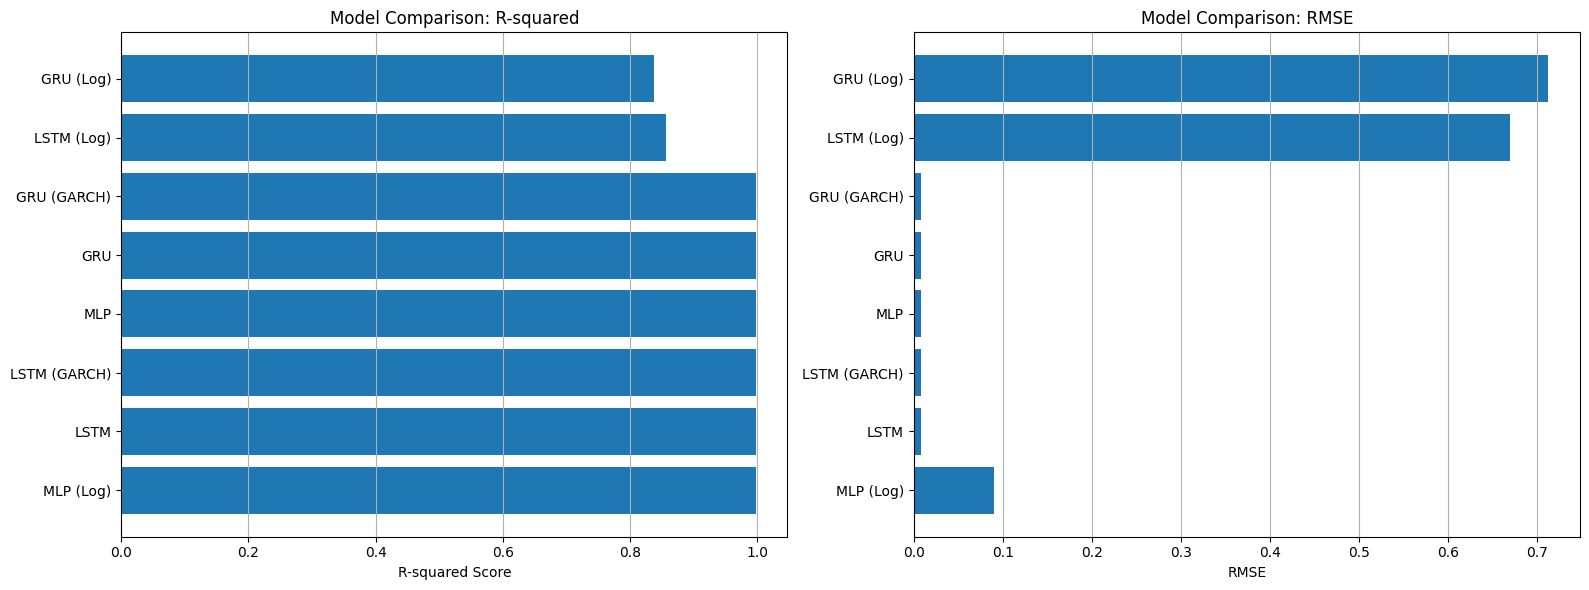

In [60]:
# Visualize model comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# R-squared comparison
ax1.barh(comparison_df['Model'], comparison_df['R-squared'])
ax1.set_xlabel('R-squared Score')
ax1.set_title('Model Comparison: R-squared')
ax1.grid(True, axis='x')

# RMSE comparison
ax2.barh(comparison_df['Model'], comparison_df['RMSE'])
ax2.set_xlabel('RMSE')
ax2.set_title('Model Comparison: RMSE')
ax2.grid(True, axis='x')

plt.tight_layout()
plt.show()
